# Cartpole DQN

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
import random
import gym
import numpy as np
from collections import deque
import tensorflow as tf
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam
from matplotlib import animation
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [3]:
stream = os.popen('nvcc --version')
cuda_version = stream.read()
print(cuda_version)
print('Tensorflow version: ', tf.__version__)
print('Keras version: ', keras.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Wed_Oct_23_19:32:27_Pacific_Daylight_Time_2019
Cuda compilation tools, release 10.2, V10.2.89

Tensorflow version:  2.1.0
Keras version:  2.3.1


#### Set Params

In [4]:
env =  gym.make('CartPole-v0')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
batch_size = 32
n_episdose = 500
output_dir = './model_output/'
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

#### Define Agent


In [5]:
class DQNAgent:
    def __init__(self, state_size, action_size, final_activation):
        
        self.state_size = state_size
        self.action_size = action_size
        self.final_activation = final_activation

        self.memory = deque(maxlen=2000)

        self.gamma = 0.95

        self.epsilon = 1.0
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01

        self.learning_rate = 0.001
    
        self.model = self._build_model()
    
    def _build_model(self):
        
        model =Sequential()

        model.add(Dense(24, input_dim = self.state_size, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation=self.final_activation))
        
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))

        return model
    
    def remember(self, state, action, reward, next_state, done):
    
        self.memory.append((state, action, reward, next_state, done))
    
    def act(self, state):
    
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])
    
    def replay(self, batch_size):

        mini_batch = random.sample(self.memory, batch_size)

        for state, action, reward, next_state, done in mini_batch:
            target = reward
            if not done:
                target = (reward + self.gamma * np.amax(self.model.predict(next_state)[0]))
            target_f = self.model.predict(state)
            target_f[0][action] = target

            self.model.fit(state, target_f, epochs=1, verbose=0)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
    
    def load(self, name):
        self.model.load_weights(name)
    
    def save(self, name):
        self.model.save_weights(name)

#### Interact with environment

In [6]:
def save_frames_as_gif(frames, path='./', filename='gym_animation.gif'):

    #Mess with this to change frame size
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=72)

    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    anim.save(path + filename, writer='imagemagick', fps=60)

episode: 0/500, score: 29, e: 1.0
episode: 1/500, score: 32, e: 0.86
episode: 2/500, score: 14, e: 0.8
episode: 3/500, score: 15, e: 0.74
episode: 4/500, score: 21, e: 0.67
episode: 5/500, score: 21, e: 0.6
episode: 6/500, score: 10, e: 0.57
episode: 7/500, score: 29, e: 0.5
episode: 8/500, score: 21, e: 0.45
episode: 9/500, score: 9, e: 0.43
episode: 10/500, score: 81, e: 0.28
episode: 11/500, score: 36, e: 0.24
episode: 12/500, score: 64, e: 0.17
episode: 13/500, score: 135, e: 0.088
episode: 14/500, score: 79, e: 0.059
episode: 15/500, score: 45, e: 0.047
episode: 16/500, score: 105, e: 0.028
MovieWriter imagemagick unavailable; using Pillow instead.
episode: 17/500, score: 199, e: 0.01


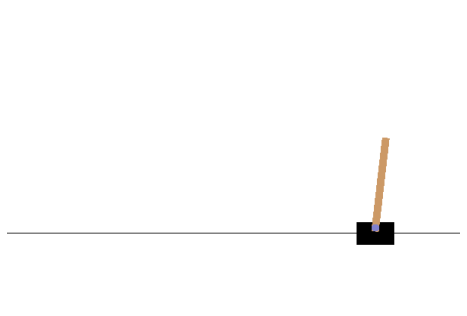

In [7]:
best_time = 0
best_frames = []
agent = DQNAgent(state_size, action_size, 'linear')
done = False
for e in range(n_episdose):
    state = env.reset()
    state = np.reshape(state, [1, state_size])
    frames = []
    for time in range(5000):

        #env.render()
        frames.append(env.render(mode="rgb_array"))
        
        action = agent.act(state)

        next_state, reward, done, _ = env.step(action)

        reward = reward if not done else -10

        next_state = np.reshape(next_state, [1, state_size])

        agent.remember(state, action, reward, next_state, done)

        state = next_state

        if done:
            print('episode: {}/{}, score: {}, e: {:.2}'.format(e, n_episdose, time, agent.epsilon))
            break

        if len(agent.memory) > batch_size:
            agent.replay(batch_size)

        if e % 50 == 0:
            agent.save(output_dir + 'weights_' + '{:04d}'.format(e) + '.hdf5')
    if time > best_time:
        best_time = time
        best_frames = frames
    
    if time > 198:
         break
        
save_frames_as_gif(best_frames)